In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import time
from tqdm.auto import tqdm

In [36]:
class TrianglesGenerator:
    
    def __init__(self, file, chromosome_length, population_size, number_of_iterations,\
                 number_of_offspring, number_of_parents, sigma_t, sigma_c, new_triangles_frequency=100, log_frequency=200,\
                 mutation_probability = 0.3, frames_frequency=10):
        
        self.A = plt.imread(file)
        self.width, self.height = self.A.shape[1], self.A.shape[0]
        self.actual_img = Image.new("RGB", (self.width, self.height))
        self.objective_function = self.objective_function_mse
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.number_of_iterations = number_of_iterations
        self.number_of_offspring = number_of_offspring
        self.number_of_parents = number_of_parents
        self.mut_ppb = mutation_probability
        self.frames_frequency = frames_frequency
        self.new_triangles_frequency = new_triangles_frequency
        self.log_frequency = log_frequency
        self.c_domain = np.array([255,255,255,255])
        self.t_domain = np.array([self.width - 1, self.height - 1])
        self.num_trian = 0
        self.sigma_t = sigma_t
        self.sigma_c = sigma_c
        #self.best_sequence_t = []
        #self.best_sequence_c = []
        
    def reset_act_image(self):
        self.actual_img = Image.new("RGB", (self.width, self.height))
        
    def show_image(self, image):
        plt.imshow(image)
        plt.show()

    def save_image(self, image, out):
        im = Image.fromarray(np.asarray(image))
        im.save(out)
        
    def draw_triangle(self, triangle, colors, B):
        t_draw = ImageDraw.Draw(B, "RGBA")
        coords = tuple(map(tuple, triangle))
        t_draw.polygon(coords, colors)
    
    def show_sequence(self, s_t, s_c):
        B = Image.new("RGB", (self.width, self.height))
        for i in range(len(s_t)):
            for j in range(s_t[i].shape[0]):
                self.draw_triangle(s_t[i][j], tuple(s_c[i][j]), B)
        return B
    
    def create_triangles(self, T, C):
        B = self.actual_img.copy()
        for i in range(T.shape[0]):
            self.draw_triangle(T[i], tuple(C[i]), B)
        return B
    
    def update_act_img(self, T, C):
        for i in range(T.shape[0]):
            self.draw_triangle(T[i], tuple(C[i]), self.actual_img)
    
    def objective_function_mse(self, T, C):
        B = self.create_triangles(T, C)
        x1 = np.asarray(self.A, dtype=int)
        x2 = np.asarray(B, dtype=int)
        return np.sum((x1 - x2)**2) / (self.width * self.height)
    
    def generate_random_population(self):
        
        self.current_population_triangles = np.around(
            self.t_domain * np.random.rand(self.population_size, self.chromosome_length, 3, 2))
            
        self.current_population_colors = np.around(
                self.c_domain * np.random.rand(self.population_size, self.chromosome_length, 4))
    
    def evolve(self, debug=False):
        
        self.best_sequence_t = []
        self.best_sequence_c = []
        
        best_triangles = np.empty((1, self.chromosome_length, 3, 2))
        best_colors = np.empty((1, self.chromosome_length, 4))
        best_solution_objective_value = np.Inf
        
        self.log_objective_values = np.empty((self.number_of_iterations, 4))
        self.log_best_triangles = np.empty((self.number_of_iterations, self.chromosome_length, 3, 2))
        self.log_best_colors = np.empty((self.number_of_iterations, self.chromosome_length, 4))
        
        self.log_frames = []
        
        
        # generating an initial population
        self.generate_random_population()
        
        current_population_objective_values = np.zeros(self.population_size)
        
        for i in range(self.population_size):
            current_population_objective_values[i] = self.objective_function(self.current_population_triangles[i, :].astype(int), self.current_population_colors[i, :].astype(int))
            
        for t in tqdm(range(self.number_of_iterations)):
            
            # modify sigma after fixed time
            #if t == int(0.3 * self.number_of_iterations):
            #    self.sigma_t *= 2/3
            #if t == int(0.7 * self.number_of_iterations):
            #    self.sigma_t *= 1/3
            
            # selecting the parent indices by the roulette wheel method
            fitness_values = current_population_objective_values.max() - current_population_objective_values
            if fitness_values.sum() > 0:
                fitness_values = fitness_values / fitness_values.sum()
            else:
                fitness_values = 1.0 / self.population_size * np.ones(self.population_size)
            parent_indices = np.random.choice(self.population_size, (self.number_of_offspring, self.number_of_parents), True, fitness_values).astype(np.int64)

            # creating the children population by Global Intermediere Recombination
            children_population_triangles = np.zeros((self.number_of_offspring, self.chromosome_length, 3, 2))
            children_population_colors = np.zeros((self.number_of_offspring, self.chromosome_length, 4))

            for i in range(self.number_of_offspring):
                children_population_triangles[i, :] = self.current_population_triangles[parent_indices[i, :], :].mean(axis=0) 
                children_population_colors[i, :] = self.current_population_colors[parent_indices[i, :], :].mean(axis=0)
             
            #mutating triangles and colors
            for i in range(self.number_of_offspring):
                for j in range(self.chromosome_length):
                    mut_vec = (np.random.rand(3) < self.mut_ppb).astype(int)
                    children_population_triangles[i][j][:, 0] += mut_vec * (self.sigma_t * self.width * np.random.randn(3))
                    children_population_triangles[i][j][:, 1] += mut_vec * (self.sigma_t * self.height * np.random.randn(3))
                    
            for i in range(self.number_of_offspring):
                for j in range(self.chromosome_length):
                    mut_vec = (np.random.rand(4) < self.mut_ppb).astype(int)
                    children_population_colors[i][j] += mut_vec * (self.sigma_c * 255 * np.random.randn(4))

            # check domains
            children_population_triangles[children_population_triangles < 0] = 0
            (children_population_triangles[:,:,:,0])[children_population_triangles[:,:,:,0] > self.t_domain[0]] = self.t_domain[0]
            (children_population_triangles[:,:,:,1])[children_population_triangles[:,:,:,1] > self.t_domain[1]] = self.t_domain[1]
            children_population_colors[children_population_colors < 0] = 0
            children_population_colors[children_population_colors > self.c_domain[1]] = self.c_domain[1]


            # evaluating the objective function on the children population
            children_population_objective_values = np.zeros(self.number_of_offspring)
            for i in range(self.number_of_offspring):
                children_population_objective_values[i] = self.objective_function(children_population_triangles[i, :].astype(int), children_population_colors[i, :].astype(int))

            # replacing the current population by (Mu + Lambda) Replacement
            current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
            self.current_population_triangles = np.vstack([self.current_population_triangles, children_population_triangles])         
            self.current_population_colors = np.vstack([self.current_population_colors, children_population_colors])


            I = np.argsort(current_population_objective_values)
            self.current_population_triangles = self.current_population_triangles[I[:self.population_size], :]
            self.current_population_colors = self.current_population_colors[I[:self.population_size], :]
            current_population_objective_values = current_population_objective_values[I[:self.population_size]]

            # recording some statistics
            if best_solution_objective_value > current_population_objective_values[0]:
                
                best_triangles = self.current_population_triangles[0, :]
                best_colors = self.current_population_colors[0, :]
                best_solution_objective_value = current_population_objective_values[0]
                
            self.log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]

            self.log_best_triangles[t, :] = self.current_population_triangles[0, :]
            self.log_best_colors[t, :] = self.current_population_colors[0, :]
            
            # creating gif
            if np.mod(t + 1, self.frames_frequency) == 0:
                obj_v = current_population_objective_values[0]
                B = self.create_triangles(self.current_population_triangles[0, :].astype(int), self.current_population_colors[0, :].astype(int))
                draw = ImageDraw.Draw(B)
                draw.text((int(self.width/40), int(self.height/40)), f'iterations:{t}\nnum of triangles:{self.num_trian}\nfitness value:{obj_v:.2f}')
                self.log_frames.append(B)
            
            #check whether to reset population and add triangles to image
            if np.mod(t + 1, self.new_triangles_frequency) == 0:
                
                self.update_act_img(best_triangles.astype(int), best_colors.astype(int))
                self.generate_random_population()
                
                self.num_trian += self.chromosome_length
                obj_v = current_population_objective_values[0]
                B = self.actual_img.copy()
                draw = ImageDraw.Draw(B)
                draw.text((int(self.width/40), int(self.height/40)), f'iterations:{t}\nnum of triangles:{self.num_trian}\nfitness value:{obj_v:.2f}')
                self.log_frames.append(B)
                
                current_population_objective_values = np.zeros(self.population_size)
                for i in range(self.population_size):
                    current_population_objective_values[i] = self.objective_function(self.current_population_triangles[i, :].astype(int), self.current_population_colors[i, :].astype(int))
                
                self.best_sequence_t.append(best_triangles.astype(int))
                self.best_sequence_c.append(best_colors.astype(int))
                
                best_triangles = np.empty((1, self.chromosome_length, 3, 2))
                best_colors = np.empty((1, self.chromosome_length, 3))
                best_solution_objective_value = np.Inf
            
            if debug and np.mod(t, self.log_frequency) == 0:
                self.show_image(self.actual_img)
                print("Iteration %d : best score = %0.8f, mean score = %0.8f." % (t, self.log_objective_values[:t+1, 0].min(), self.log_objective_values[t, 2]))
                
    def show_statistics(self):
        plt.figure(figsize=(18, 4))
        print(f'Lowes obj value: {self.log_objective_values[:,0].min()}')
        plt.plot(self.log_objective_values[:, 0], 'r-')
        plt.plot(self.log_objective_values[:, 1], 'g-')
        plt.plot(self.log_objective_values[:, 2], 'b-')
        plt.xlabel('iteration')
        plt.ylabel('objective function value')
        plt.title('min/avg/max objective function values')
        plt.show()
        
    def save_results(self, title, frames_freq=0):
        self.result = self.show_sequence(self.best_sequence_t, self.best_sequence_c)
        self.save_image(self.result, (title + '.jpg'))
        frames = self.log_frames.copy()
        if frames_freq > 0:
            frames = frames[::frames_freq]
        frames[0].save((title + '.gif'), save_all=True, append_images=frames[1:], optimize=False, duration=1, loop=0)
        
    

In [3]:
chrom_len = 2
pop_size = 10
iterations = 50000
kids_num = 200
parents_num = 2
sigma_t = 1/6
sigma_c = 1/6
new_triangles_freq = 250
log_freq = 5000
#400 trojkatow
mutation_probability = 0.3
frames_frequency = 50

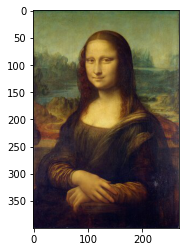

In [16]:
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
mona_lisa = TrianglesGenerator('mona_lisa.jpeg', *args)
mona_lisa.show_image(mona_lisa.A)

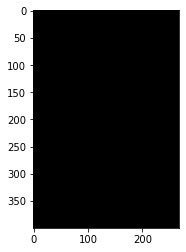

Iteration 0 : best score = 17317.98456157, mean score = 17914.78595056.


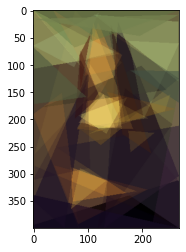

Iteration 5000 : best score = 827.34172575, mean score = 856.53986194.


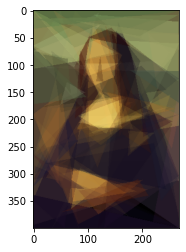

Iteration 10000 : best score = 570.22704291, mean score = 590.19863806.


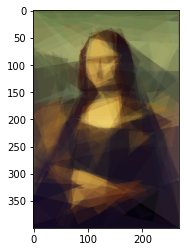

Iteration 15000 : best score = 464.85081157, mean score = 496.86588619.


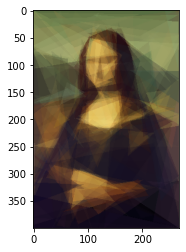

Iteration 20000 : best score = 402.88044776, mean score = 438.80100933.


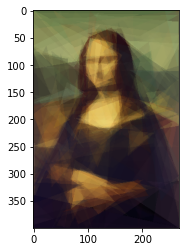

Iteration 25000 : best score = 368.02409515, mean score = 385.63012873.


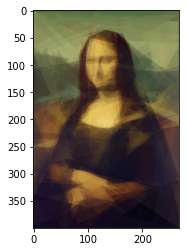

Iteration 30000 : best score = 339.88460821, mean score = 473.27575840.


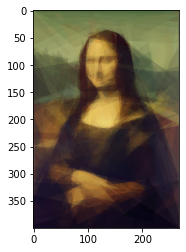

Iteration 35000 : best score = 318.94987873, mean score = 334.60501959.


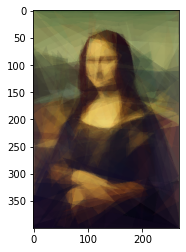

Iteration 40000 : best score = 304.80419776, mean score = 322.91718004.


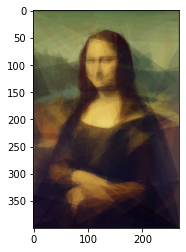

Iteration 45000 : best score = 291.94688433, mean score = 318.83899440.



In [17]:
mona_lisa.evolve(debug=True)

Lowes obj value: 278.701651119403


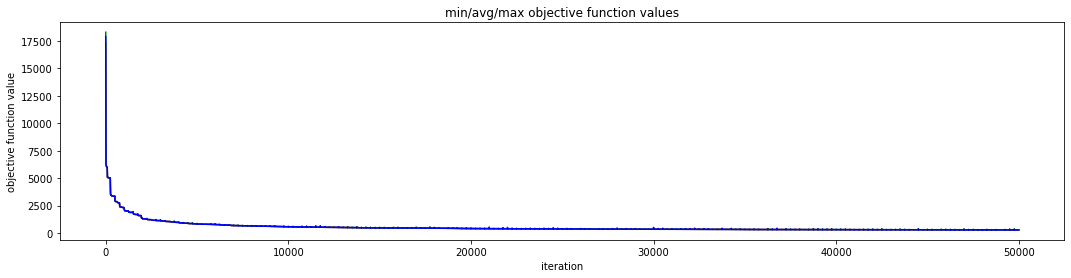

In [18]:
mona_lisa.show_statistics()

In [19]:
mona_lisa.save_results("mona_lisa")

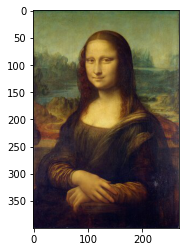

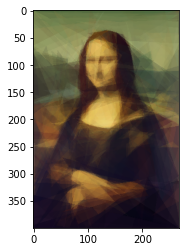

In [20]:
mona_lisa.show_image(mona_lisa.A)
mona_lisa.show_image(mona_lisa.result)

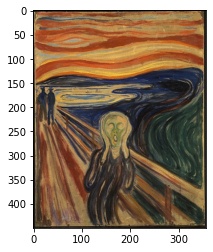

In [6]:
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
scream = TrianglesGenerator('krzyk.jpg', *args)
scream.show_image(scream.A)

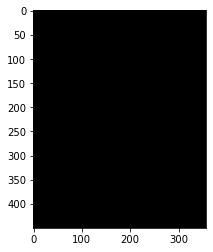

Iteration 0 : best score = 22296.30019863, mean score = 23402.57062446.


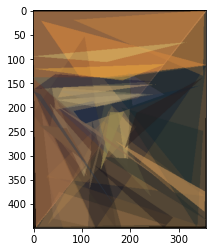

Iteration 5000 : best score = 2241.10348852, mean score = 2246.02010490.


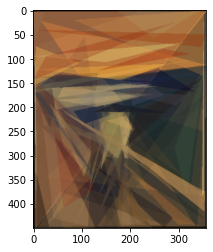

Iteration 10000 : best score = 1760.11500931, mean score = 1788.07879640.


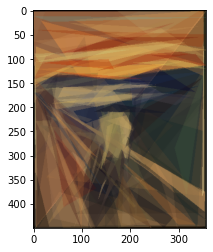

Iteration 15000 : best score = 1454.92155804, mean score = 1471.49301924.


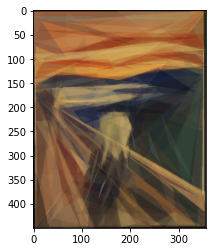

Iteration 20000 : best score = 1334.38886406, mean score = 1344.47490255.


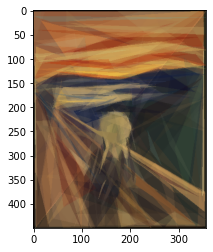

Iteration 25000 : best score = 1261.01380509, mean score = 1279.06070577.


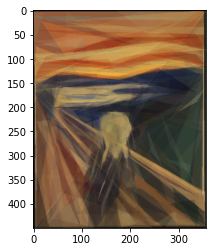

Iteration 30000 : best score = 1188.23070764, mean score = 1218.80106021.


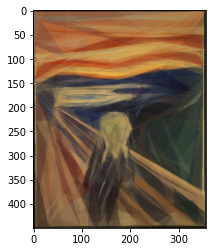

Iteration 35000 : best score = 1118.09021726, mean score = 1144.19754935.


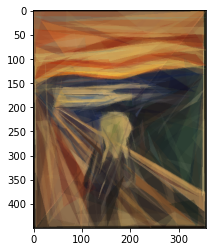

Iteration 40000 : best score = 1073.85736189, mean score = 1101.39466480.


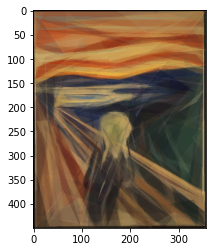

Iteration 45000 : best score = 1012.25283054, mean score = 1043.85580447.



In [11]:
scream.evolve(debug=True)

Lowes obj value: 965.6865363128492


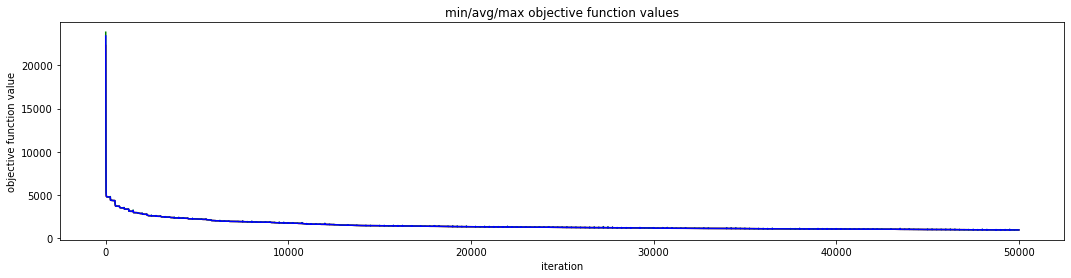

In [14]:
scream.show_statistics()

In [15]:
scream.save_results("scream")

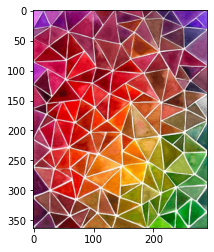

In [7]:
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
triangles = TrianglesGenerator('triangles_small.jpg', *args)
triangles.show_image(triangles.A)

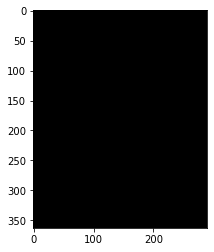

Iteration 0 : best score = 34363.64271872, mean score = 37826.39443336.


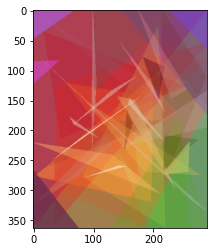

Iteration 5000 : best score = 8233.69206802, mean score = 8271.49119312.


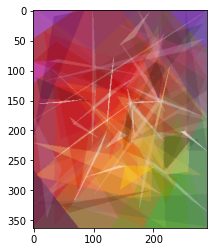

Iteration 10000 : best score = 7378.58058326, mean score = 7411.54913746.


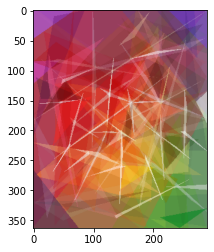

Iteration 15000 : best score = 6582.78056426, mean score = 6598.13442386.


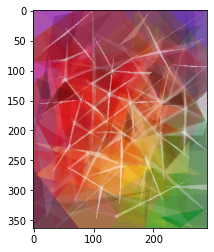

Iteration 20000 : best score = 6014.46690415, mean score = 6025.82268168.


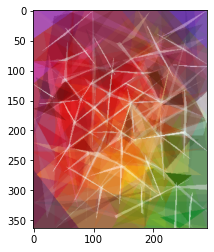

Iteration 25000 : best score = 5556.63398879, mean score = 5575.86401634.


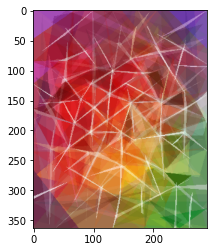

Iteration 30000 : best score = 5228.66789209, mean score = 5253.96673031.


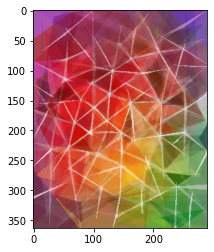

Iteration 35000 : best score = 4973.32089864, mean score = 4987.22128527.


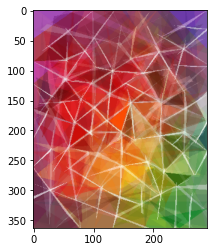

Iteration 40000 : best score = 4566.27564358, mean score = 4581.17947753.


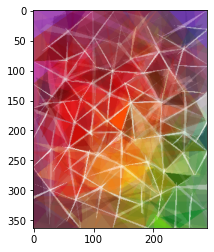

Iteration 45000 : best score = 4335.44283272, mean score = 4416.07487223.



In [10]:
triangles.evolve(debug=True)

Lowes obj value: 4141.9254583452075


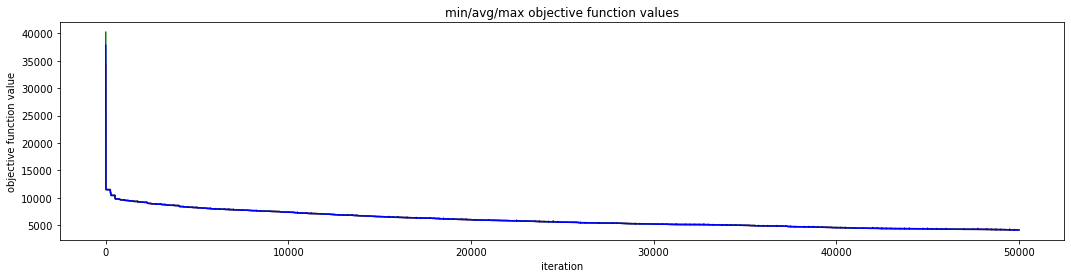

In [16]:
triangles.show_statistics()

In [17]:
triangles.save_results("triangles")

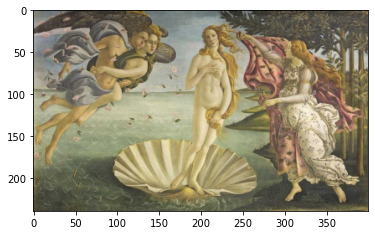

In [4]:
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
venus = TrianglesGenerator('venus_small.jpg', *args)
venus.show_image(venus.A)

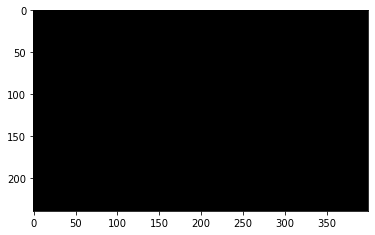

Iteration 0 : best score = 35218.84214583, mean score = 41981.14171771.


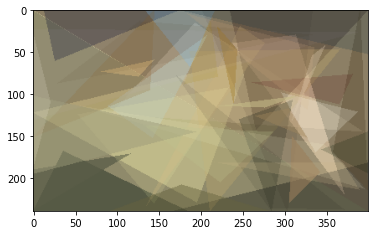

Iteration 5000 : best score = 2020.37343750, mean score = 2081.70399896.


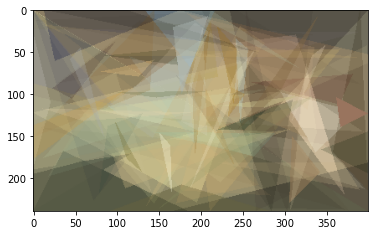

Iteration 10000 : best score = 1723.57087500, mean score = 1743.89475104.


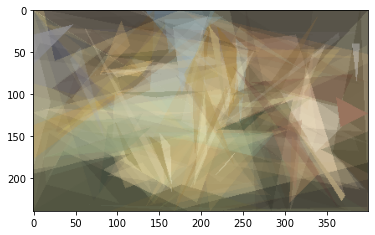

Iteration 15000 : best score = 1515.02191667, mean score = 1534.63198854.


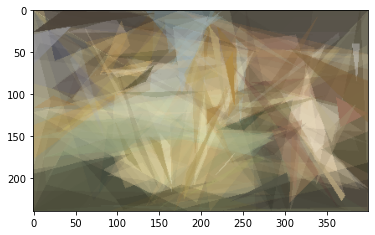

Iteration 20000 : best score = 1375.51140625, mean score = 1384.31560417.


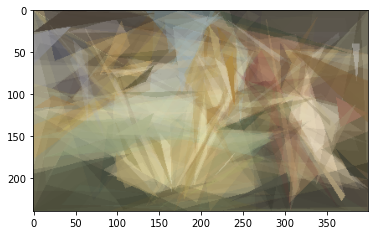

Iteration 25000 : best score = 1288.90379167, mean score = 1303.99251354.


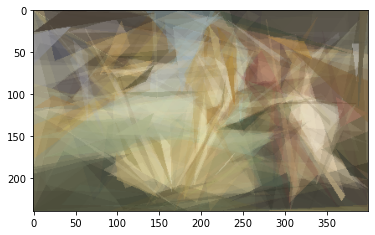

Iteration 30000 : best score = 1224.57465625, mean score = 1250.66886146.


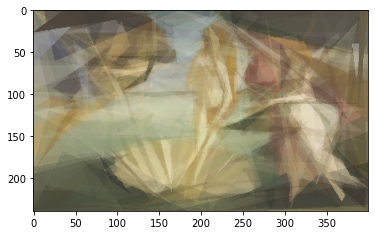

Iteration 35000 : best score = 1164.44958333, mean score = 1180.33468958.


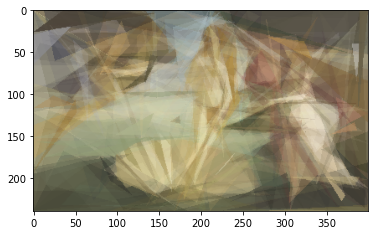

Iteration 40000 : best score = 1123.30412500, mean score = 1156.63056250.


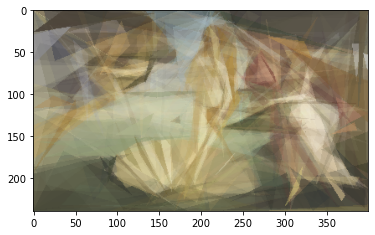

Iteration 45000 : best score = 1075.74783333, mean score = 1101.52258958.



In [5]:
venus.evolve(debug=True)

Lowes obj value: 1044.0285625


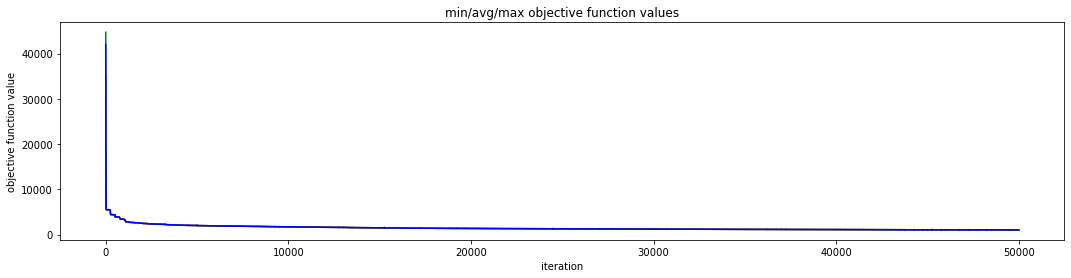

In [6]:
venus.show_statistics()

In [7]:
venus.save_results("venus")

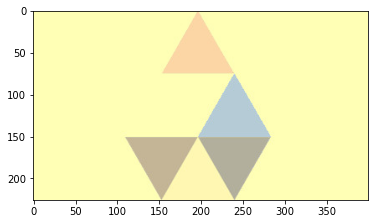

In [6]:
iterations = 30000
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
test = TrianglesGenerator('test.jpg', *args)
test.show_image(test.A)

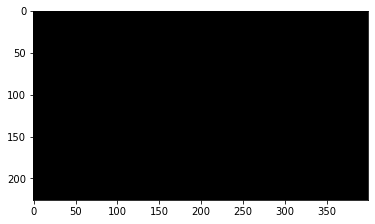

Iteration 0 : best score = 120784.28724558, mean score = 127386.96305973.


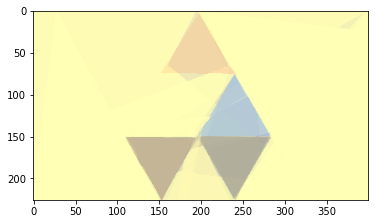

Iteration 5000 : best score = 28.93116150, mean score = 88.27475774.


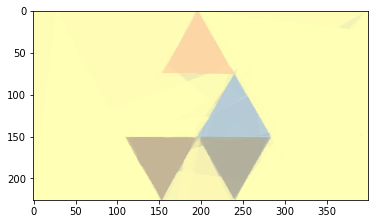

Iteration 10000 : best score = 20.55067478, mean score = 37.89173783.


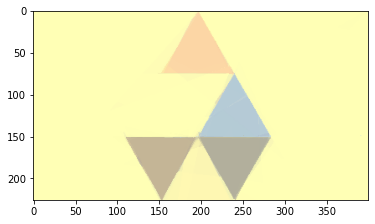

Iteration 15000 : best score = 12.38570796, mean score = 81.78687942.


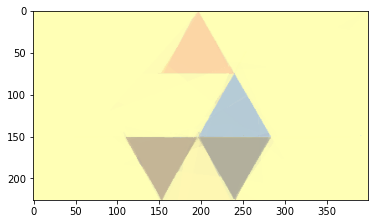

Iteration 20000 : best score = 11.08252212, mean score = 64.90033075.


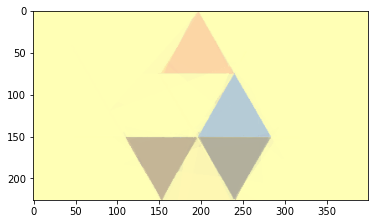

Iteration 25000 : best score = 9.19058628, mean score = 23.96696571.



In [7]:
test.evolve(debug=True)

Lowes obj value: 8.046537610619469


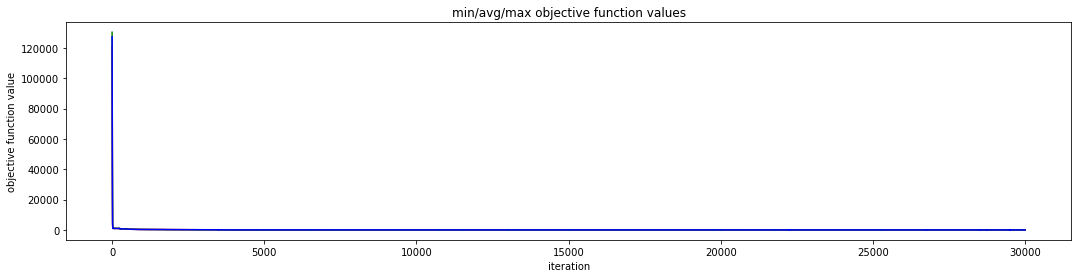

In [8]:
test.show_statistics()

In [9]:
test.save_results("test")

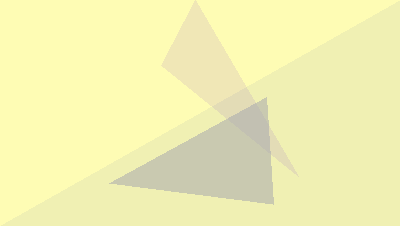

In [18]:
test.show_sequence(test.best_sequence_t[:2], test.best_sequence_c[:2])

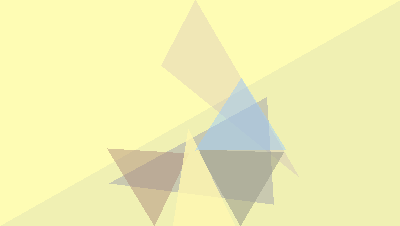

In [13]:
test.show_sequence(test.best_sequence_t[:4], test.best_sequence_c[:4])

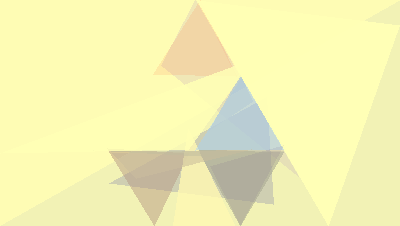

In [14]:
test.show_sequence(test.best_sequence_t[:10], test.best_sequence_c[:10])

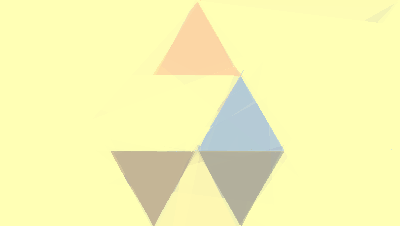

In [16]:
test.show_sequence(test.best_sequence_t[:50], test.best_sequence_c[:50])

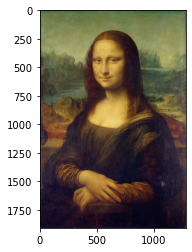

In [9]:
iterations = 7000
log_freq = 1000
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
mona_lisa_b = TrianglesGenerator('MonaLisa.jpg', *args)
mona_lisa_b.show_image(mona_lisa_b.A)

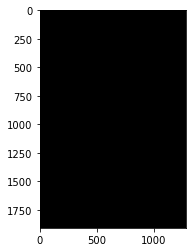

Iteration 0 : best score = 17578.50582948, mean score = 18384.76142545.


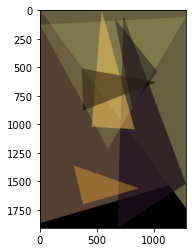

Iteration 1000 : best score = 3509.99755511, mean score = 3542.53745770.


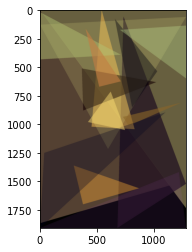

Iteration 2000 : best score = 2674.86552182, mean score = 2720.20024076.


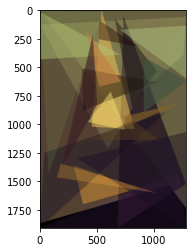

Iteration 3000 : best score = 2251.65555474, mean score = 2267.63164709.


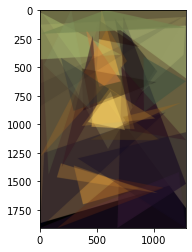

Iteration 4000 : best score = 2042.89328854, mean score = 2063.34653523.


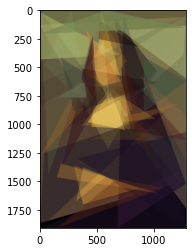

Iteration 5000 : best score = 1953.92990492, mean score = 1995.20758304.


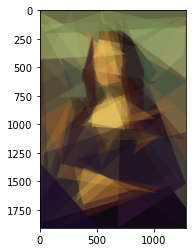

Iteration 6000 : best score = 1805.35873256, mean score = 1829.56973733.



In [10]:
mona_lisa_b.evolve(debug=True)

Lowes obj value: 1759.2622244333072


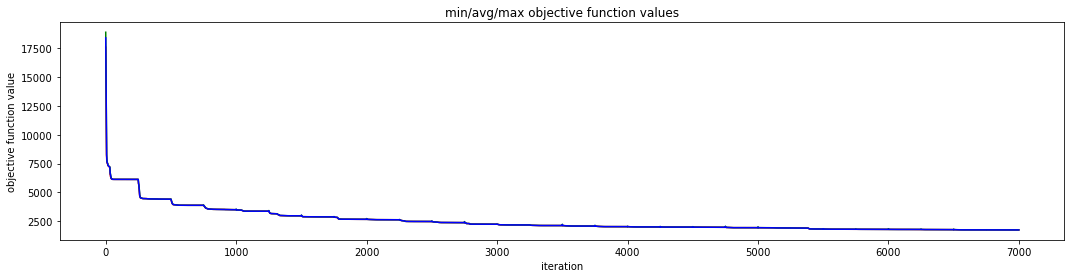

In [11]:
mona_lisa_b.show_statistics()

In [12]:
mona_lisa_b.save_results("mona_lisa_b")

## SCALING

In [25]:
def rescale(w_0, h_0, w_1, h_1, triangles):
    width_scale = w_1 / w_0
    height_scale = h_1 / h_0
    new_triangles = np.copy(triangles)#np.zeros([triangles.shape[0], triangles.shape[1], 3 ,2])
    new_triangles[:,:,:,0] =  np.around(new_triangles[:,:,:,0] * width_scale)
    new_triangles[:,:,:,1] = np.around(new_triangles[:,:,:,1] * height_scale)
    return new_triangles

In [26]:
chrom_len = 2
pop_size = 10
iterations = 25000
kids_num = 200
parents_num = 2
sigma_t = 1/6
sigma_c = 1/6
new_triangles_freq = 200
log_freq = 2500
#250 trojkatow
mutation_probability = 0.3
frames_frequency = 50

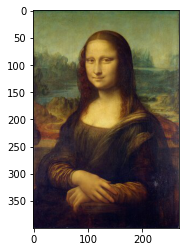

In [27]:
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
small_mona_lisa = TrianglesGenerator('mona_lisa.jpeg', *args)
small_mona_lisa.show_image(small_mona_lisa.A)

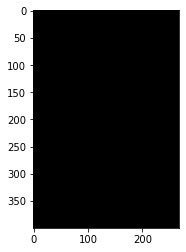

Iteration 0 : best score = 15214.50498134, mean score = 16402.96971828.


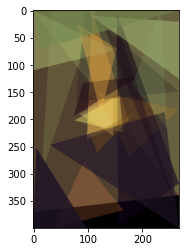

Iteration 1500 : best score = 1346.64111007, mean score = 1386.89912873.


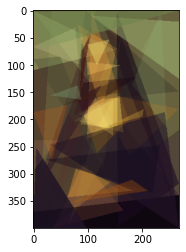

Iteration 3000 : best score = 844.68520522, mean score = 900.23482743.


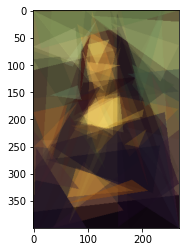

Iteration 4500 : best score = 697.16271455, mean score = 701.72037034.


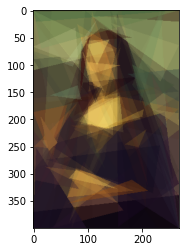

Iteration 6000 : best score = 589.38907649, mean score = 630.39501119.


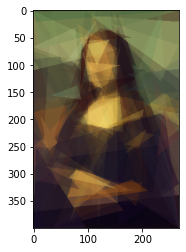

Iteration 7500 : best score = 549.27910448, mean score = 581.28516884.


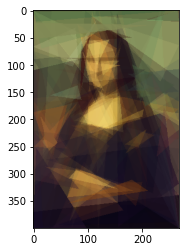

Iteration 9000 : best score = 506.58916978, mean score = 551.97010448.


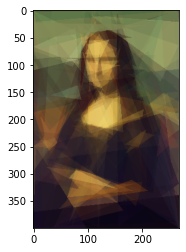

Iteration 10500 : best score = 467.34145522, mean score = 475.37550187.


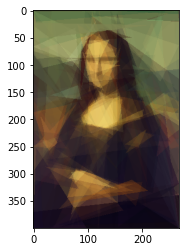

Iteration 12000 : best score = 432.80492537, mean score = 445.78240392.


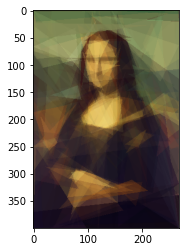

Iteration 13500 : best score = 417.94694963, mean score = 448.27487034.



In [28]:
small_mona_lisa.evolve(debug=True)

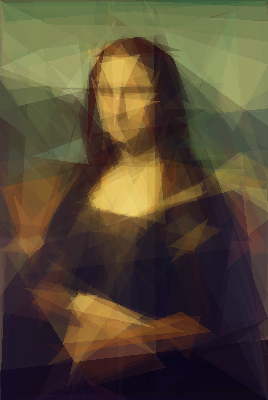

In [29]:
best_triangles = small_mona_lisa.best_sequence_t
best_colors = small_mona_lisa.best_sequence_c
small_mona_lisa.show_sequence(best_triangles, best_colors)

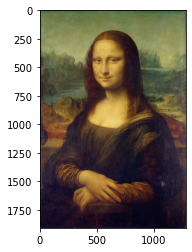

In [37]:
iterations = 1500
new_triangles_freq = 100
log_freq = 400
args = [chrom_len, pop_size, iterations, kids_num, parents_num, sigma_t, sigma_c,
        new_triangles_freq, log_freq, mutation_probability, frames_frequency]
big_mona_lisa = TrianglesGenerator('MonaLisa.jpg', *args)
big_mona_lisa.show_image(big_mona_lisa.A)

In [38]:
scaled_triangles = rescale(small_mona_lisa.width, small_mona_lisa.height, big_mona_lisa.width, big_mona_lisa.height, best_triangles)

In [39]:
big_mona_lisa.actual_img = big_mona_lisa.show_sequence(scaled_triangles, best_colors)

In [40]:
big_mona_lisa.best_sequence_t = scaled_triangles
big_mona_lisa.best_sequence_c = best_colors

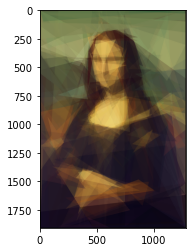

In [41]:
big_mona_lisa.show_image(big_mona_lisa.actual_img)

In [45]:
big_mona_lisa.save_image(big_mona_lisa.actual_img, "scaled_lisa.jpg")

In [ ]:
big_mona_lisa.evolve(debug=True)

In [36]:
#big_mona_lisa.show_sequence(scaled_triangles, best_colors)

In [72]:
im = Image.open("mona_lisa.gif")
for i in range(0,1198,100):
    im.seek(i)
    im.save(f'raport/frames/mona_lisa{i // 100}.png')

In [73]:
im = Image.open("scream.gif")
for i in range(0,1198,100):
    im.seek(i)
    im.save(f'raport/frames/scream{i // 100}.png')

In [74]:
im = Image.open("triangles.gif")
for i in range(0,1198,100):
    im.seek(i)
    im.save(f'raport/frames/triangles{i // 100}.png')

In [75]:
im = Image.open("venus.gif")
for i in range(0,1198,100):
    im.seek(i)
    im.save(f'raport/frames/venus{i // 100}.png')

In [79]:
im = Image.open("test.gif")
for i in range(0,800,100):
    im.seek(i)
    im.save(f'raport/frames/test{i // 100}.png')